# Loading wikipedia bios

## loading raw identities

In [27]:
import pandas as pd
from ast import literal_eval


df = pd.read_csv('FinalDataFrame5.csv')
df.identities = df.identities.apply(literal_eval)
bios = list(df['identities'])

bios[:5]

[['rapper'],
 ['minister', 'Bible scholar', 'author'],
 ['astrophysicist'],
 ['snooker', 'billiards player'],
 ['Welsh sports journalist']]

In [10]:
pd.set_option("max_colwidth", None)
df.iloc[1:2]

,name_searched,context,identities
1,Renita J. Weems,"Renita J. Weems is an ordained minister, a Hebrew Bible scholar, and an author.","[minister, Bible scholar, author]"


In [ ]:
# The rest is similar to twitter bios approach

# Loading twitter bios

## load all raw data

In [31]:
import pickle
with open('/user/smadani/navid/data/pis2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    

# PI frequency and top PIs

In [32]:
from collections import Counter
cntr = Counter()

for bio in bios:
    cntr.update(bio)

print(len(bios))

15459872


In [12]:
import numpy as np

freqs = list(cntr.values())
print(f"percentile freq: {np.percentile(freqs, 90)} mean freq: {np.mean(freqs)}")

percentile freq: 9.0 mean freq: 28.606337144830846


In [14]:
most_frequent_pis = {k:v for k,v in cntr.items() if v > 10}
len(most_frequent_pis)

5106

In [115]:
import pandas as pd

df = pd.DataFrame({'pi': list(most_frequent_pis.keys()), 'cnt': list(most_frequent_pis.values())})
df = df.sort_values(by=['cnt'], ascending=False)

In [116]:
df.to_csv('wiki_most_frequent_pis.csv', index=False, header=True)

In [118]:
!head twitter_most_frequent_pis.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
pi,cnt
she,452418
her,397756
he,185793
him,154092
they,127571
fan account,124627
blacklivesmatter,101217
blm,101082
ig,93961


### most frequent neighbors

In [ ]:
from tqdm import tqdm
neighbor_cnt = {}

for bio in tqdm(bios):
    for pi in bio:
        if pi in most_frequent_pis:
            if pi not in neighbor_cnt:
                neighbor_cnt[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in most_frequent_pis]
            neighbor_cnt[pi].update(rest)

print(len(neighbor_cnt))            

#post processing and pruning empty adjacencies

for pi, adj in neighbor_cnt.copy().items():
    if len(adj) < 2:
        neighbor_cnt.pop(pi)
    
print(f"size after pruning: {len(neighbor_cnt)}")        

### calculating tf-idf

In [ ]:
for pi, neighs in tqdm(neighbor_cnt.items()):
    for phrase in neighs.keys():
        neighs[phrase] /= most_frequent_pis[phrase]
        

### calculating using bi-partite method

In [ ]:
from scipy import sparse, io

pi_idx = {}
for pi in most_frequent_pis:
    pi_idx[pi] = len(pi_idx)

#creating bipartite matrix
usr_pi = []

for bio in bios:
    cur_usr_pis = []
    for pi in bio:
        if pi in most_frequent_pis:
            cur_usr_pis.append(pi_idx[pi])
    if len(cur_usr_pis) < 2:
        continue
    usr_pi.append(cur_usr_pis)
    

print(f"original users: {len(bios)}")
print(f"no of users after pruning: {len(usr_pi)}")


In [ ]:
usrs = []
pis = []
scores = []

for uid, pis in enumerate(usr_pi):
    for pi in pis:
        usrs.append(uid)
        pis.append(pi)
        scores.append(1)

In [ ]:
%% time

BP_MATRIX_FILENAME = "./bipartite_pi.mtx"
output_matrix = sparse.coo_matrix((scores, (usrs, pis)))
io.mmwrite(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
!du -hs ./bipartite_pi.mtx

In [ ]:
from scipy import io

io.mmread(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
scores

In [ ]:
!rm ./bipartite_pi.mtx.gz
!gzip ./bipartite_pi.mtx
!ls

In [ ]:
import sys

sys.path.append("../bipartite-pairs/python-scoring/")
import score_data

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
score_data.score_only(
    BP_MATRIX_FILENAME+".gz",
    ['weighted_corr_exp'],
    BP_SCORING_OUTPUT,
)

In [ ]:
!zcat ./bipartite_output.csv.gz

In [ ]:
import pandas as pd

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
df = pd.read_csv(BP_SCORING_OUTPUT)
df.head()

In [ ]:
# recreate the neighboring dictionary



### save 

In [ ]:
import pandas as pd

pis = []
positives = []
negatives = []

for pi, cntr in tqdm(neighbor_cnt.items()):
    cur_neg = [x for x in most_frequent_pis if x not in neighbor_cnt[pi]]
    if len(cur_neg) > 20:
        cur_neg = list(np.random.choice(cur_neg, size=20, replace=False))
    cur_pos = [x[0] for x in neighbor_cnt[pi].most_common(5)]
    if len(cur_neg) < 4 or len(neighbor_cnt[pi])<2:
        print(f"PASSING PI: {pi}")
        continue
    positives.append(cur_pos)
    pis.append(pi)
    negatives.append(cur_neg)
                 
print(f"saving {len(pis)} pis")
df = pd.DataFrame({'pis': pis, 'positives': positives, 'negatives': negatives})
df.to_csv('twitter_pi_with_neighbors_tfidf.csv', index=False, header=True)

In [ ]:
!wc -l wiki_pi_with_neighbors_standard.csv

In [ ]:
!head wiki_pi_with_neighbors_standard.csv

## create train and test dataset

In [33]:
from sklearn.model_selection import train_test_split

lower_bios = []
for bio in bios:
    lower_bio = []
    for pi in bio:
        lower_bio.append(pi.lower())
    lower_bios.append(lower_bio)
    
train, test = train_test_split(lower_bios, test_size=0.2, shuffle=True)
print(len(train), len(test))



12367897 3091975


In [34]:
import pickle

dataset = 'twitter'

with open(f'./data/{dataset}_test_bios.pkl', 'wb') as f:
    pickle.dump(test, f)
    
with open(f'./data/{dataset}_train_bios.pkl', 'wb') as f:
    pickle.dump(train, f)

# Cleaning data

## phrase cleaning

In [2]:
import pickle

dataset = 'twitter'
min_freq = 10 if dataset == 'wiki' else 100

print(min_freq)
with open(f'./data/{dataset}_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)

100


In [3]:
# build a vocabulary of phrases
from tqdm import tqdm_notebook as tqdm
from collections import Counter

pi_cnt = Counter()
for bio in tqdm(bios):
    pi_cnt.update(bio)

len(pi_cnt)

/scratch/12453279/ipykernel_28533/2665102249.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bio in tqdm(bios):


  0%|          | 0/12367897 [00:00<?, ?it/s]

7860996

In [7]:
pi_cnt.most_common(10)

[('she', 361863),
 ('her', 318200),
 ('he', 148579),
 ('him', 123188),
 ('they', 102108),
 ('fan account', 99765),
 ('blm', 81032),
 ('blacklivesmatter', 80977),
 ('ig', 75124),
 ('writer', 72601)]

In [8]:
pi_cnt.most_common(len(pi_cnt))[-5:]

[('social innovation labs', 1),
 ('solutions_lab', 1),
 ('yourlawsociety', 1),
 ('im niall', 1),
 ('deepakngk', 1)]

## cleaning each bio

In [9]:
from tqdm import tqdm

# phrases of lenght at least m
# profiles with at least k phrases
# pis that's been repeated at least m times in dataset

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= min_freq:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_bios = clean_pis(bios)
print(len(cleaned_bios), len(bios))

100%|██████████| 12367897/12367897 [00:24<00:00, 514824.69it/s]

3534903 12367897


## saving cleaned dataset

In [10]:
with open(f'./data/{dataset}_cleaned_train_bios_{min_freq}.pkl', 'wb') as f:
    pickle.dump(cleaned_bios, f)

# Masked Language Modeling

## loading dataset

In [1]:
import pickle

with open('/user/smadani/navid/data/bios2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    
bios[100:150]

['UX, communication + design; tiptoeing through fields of hubris',
 'Taca y programar.',
 "The best of SBS entertainment, sport, drama, news, documentaries & more. Celebrating the world's diverse stories.",
 'Researching urban communication, emergent publics, and methods for integrating culture and design.',
 'Owner and founder of Heart Spade PR; Co-host @MemoriesMixtape; Instagram lead @persistbrooklyn; Dog walker @nyanimalrescue. (he/him)',
 "I'm a Writer. I fly spaceships. Sometimes I fight rubber monsters. I talk about TV/Movies/Music/VideoGames I enjoy as well. Lets talk. I Reply a lot. :)",
 'random internet stranger',
 'Actor, Comedian, Asian Girl Lover, Boob Expert, Video Gamer, Jedi Atheist Falcons Fan',
 'Bringing you all the latest entertainment news! \nKeep up at http://eonline.com and watch us weekdays from NYC at 7am!',
 'LISTEN UP YO, THIS IS HOT GYAL BIZNESS! Check out my latest on http://mixcloud.com/msmanya',
 'Lackwit gadabout, Software Engineer (@gitlab), 🏍 blogger,

## cleaning dataset

In [ ]:
from tqdm import tqdm
import re

## remove url and email addresses + social media links
cleaned_bios = []

for description in tqdm(bios):
    d = re.sub(r'\w+@\w+\.\w+', '', description.lower()).strip()
    d = re.sub(r'(on )?(snapchat|snap|ig|insta|instagram|email|phone): +[A-Za-z0-9_@.-]+', " ", d).strip()
    d = re.sub(r'http\S+', '', d).strip()
    d = d.replace("&emsp;", "").replace("&nbsp;", "")
    d = re.sub(r"\s+", " ", d).strip()
    if len(d) > 5:
        cleaned_bios.append(d)

len(cleaned_bios), cleaned_bios[:10]

 16%|█▌        | 2518661/16240577 [00:43<03:51, 59201.14it/s]

## domain adaptation

In [ ]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


model_checkpoint = "bert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# Contrastive learning

## generating positive negative samples

In [13]:
import pickle
import numpy as np

dataset = 'twitter'
freq = 100
    
with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
pi_set = set()
for bio in bios:
    pi_set.update(bio)
pi_set = list(pi_set)
    
len(bios), len(pi_set)

(3534903, 22516)

In [14]:
np.median([len(x) for x in bios])

3.0

### neighbors of a PI

In [15]:
from tqdm import tqdm
neighbors = {}

for bio in tqdm(bios):
    for pi in bio:
        if pi in pi_cnt:
            if pi not in neighbors:
                neighbors[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in pi_cnt]
            neighbors[pi].update(rest)

print(len(neighbors))            


100%|██████████| 3534903/3534903 [00:45<00:00, 77837.76it/s]

22516


### pos/neg samples

In [16]:
from random import randint
import numpy as np

def pair_in_list(current_pair, l):
    for pair in l:
        if current_pair[0] in pair and current_pair[1] in pair:
            return True
    return False


def generate_triplets(bios, k=3):
    samples = []
    for idx, bio in tqdm(enumerate(bios), total=len(bios)):
        if len(bio) != len(set(bio)):
            continue
        iters = min(len(bio)-1, k)
        chosen_pis = []
        for i in range(iters):
            pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            while pair_in_list([pos1,pos2], chosen_pis):
                pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            chosen_pis.append([pos1, pos2])
            neg_idx = randint(0, len(pi_set)-1)
            while pi_set[neg_idx] in neighbors[pos1] or pi_set[neg_idx] in neighbors[pos2]:
                neg_idx = randint(0, len(pi_set)-1)
            samples.append([pos1, pos2, pi_set[neg_idx]])
    return samples

triplets = generate_triplets(bios, k=3)

100%|██████████| 3534903/3534903 [03:54<00:00, 15068.34it/s]


In [19]:
print(len(triplets))

6857060


## save dataset

In [20]:
import pickle 

with open(f'data/{dataset}-triplets_{freq}.pkl', 'wb') as f:
    pickle.dump(triplets, f)

In [21]:
import pickle 

dataset = 'twitter'

with open(f'data/{dataset}-triplets_{freq}.pkl', 'rb') as f:
    triplets = pickle.load(f)

In [24]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(triplets, test_size=0.01, shuffle=True)

print(f"train size: {len(train_set)}, validation size: {len(valid_set)}")

train size: 6788489, validation size: 68571


In [25]:
import csv

# writing the data into the file
with open(f'data/{dataset}-valid-{freq}.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(valid_set)
    
with open(f'data/{dataset}-train-{freq}.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(train_set)


## finetuning

### building the dataset


In [26]:
import csv
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

dataset = 'twitter'
freq=100

with open(f'data/{dataset}-train-{freq}.csv', newline='') as f:
    train_examples = []
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        train_examples.append(InputExample(texts=[row[0], row[1]], label=1.0))
        train_examples.append(InputExample(texts=[row[0], row[2]], label=0.0))
    

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
6788489it [01:30, 74656.08it/s] 


### loading evaluation dataset

In [27]:

from sentence_transformers import evaluation

with open(f'data/{dataset}-valid.csv', newline='') as f:
    sent1s = []
    sent2s = []
    scores = []
    i = 0
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        sent1s.append(row[0])
        sent1s.append(row[0])
        sent2s.append(row[1])
        sent2s.append(row[2])
        scores.append(1.0)
        scores.append(0.0)
        i += 1
evaluator = evaluation.EmbeddingSimilarityEvaluator(sent1s, sent2s, scores)


101136it [00:00, 753099.12it/s]


### creating data loaders

In [28]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

model_name = 'all-distilroberta-v1'
model = SentenceTransformer(model_name)
# dense_model = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())
# model.add_module('3', dense_model)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=256)
train_loss = losses.CosineSimilarityLoss(model)

model

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

### training

In [ ]:
output_model_path = f'models/distilroberta-{dataset}-freq{freq}'

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=10,
          evaluation_steps=5000,
          warmup_steps=5000,
          output_path=output_model_path)

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/53036 [00:00<?, ?it/s]

### valiation results - best model


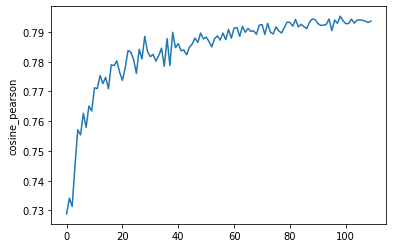

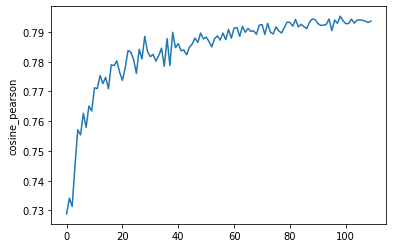

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

twitter_valid = pd.read_csv(f'models/distilroberta-{dataset}-freq{freq}/eval/similarity_evaluation_results.csv')
wiki_valid = pd.read_csv(f'models/distilroberta-{dataset}-freq{freq}/eval/similarity_evaluation_results.csv')

sns.lineplot(x=range(len(twitter_valid)), y=twitter_valid['cosine_pearson'])
plt.show()
sns.lineplot(x=range(len(wiki_valid)), y=wiki_valid['cosine_pearson'])
plt.show()

## evaluation

### loading saved model

In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [ ]:
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer('./models/miniLM-L6-finetuned-wiki/')

model

### calculating encodings for all phrases

In [ ]:
pis = set()

for bio in cleaned_bios:
    pis.update(bio)

pis = list(pis)
print(len(pis))

embeddings = model.encode(pis, convert_to_tensor=True)
        

In [ ]:
def most_similar(pi, all_pis, all_pi_embs, model, k=11):
    cur_emb = model.encode(pi, convert_to_tensor=True)
    cosine_scores = util.cos_sim(cur_emb, all_pi_embs).detach().cpu().numpy()[0]
    most_similars = np.argsort(cosine_scores)[-k:]
    return [(all_pis[i], cosine_scores[i]) for i in most_similars if pi!=all_pis[i]]

most_similar('mima', pis, embeddings, model, k=50)

In [ ]:
def get_similarity(w1, w2, model=model):
    emb1 = model.encode(w1, convert_to_tensor=True)
    emb2 = model.encode(w2, convert_to_tensor=True)
    return util.cos_sim(emb1, emb2)

print(
    get_similarity('isfj', 'man'),
    get_similarity('isfj', 'woman'),
    get_similarity('isfj', 'man', model=model),
    get_similarity('isfj', 'woman', model=model),
)

print(
    get_similarity('intj', 'man'),
    get_similarity('intj', 'woman'),
    get_similarity('intj', 'man', model=model),
    get_similarity('intj', 'woman', model=model),
)

print(
    get_similarity('entj', 'man'),
    get_similarity('entj', 'woman'),
    get_similarity('entj', 'man', model=model),
    get_similarity('entj', 'woman', model=model),
)


In [ ]:
mom_emb = base_model.encode('intp', convert_to_tensor=True)
dad_emb = base_model.encode('esfj', convert_to_tensor=True)
util.cos_sim(mom_emb, dad_emb)

### loading not tuned model and doing the same thing

In [ ]:
from sentence_transformers import SentenceTransformer, models

base_model = SentenceTransformer('all-MiniLM-L6-v2')
base_embs = base_model.encode(pis, convert_to_tensor=True)
base_cosine_scores = util.cos_sim(base_embs, base_embs).detach().cpu().numpy()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

target_word = 'build the wall'
df1 = pd.DataFrame(most_similar(target_word, pis, embeddings, model), columns=['identifier', 'similarity'])
df1['model'] = 'fine-tuned-sentence-bert'
df2 = pd.DataFrame(most_similar(target_word, pis, base_embs, base_model), columns=['identifier', 'similarity'])
df2['model'] = 'original-sentence-bert'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax1.scatter(x=df1['identifier'], y=df1['similarity'])
ax1.tick_params(axis='x', rotation=-60)
ax1.set_xlabel('phrase')
ax1.set_ylabel('similarity')
ax1.set_title('fine-tuned-sentence-bert')


ax2.scatter(x=df2['identifier'], y=df2['similarity'])
ax2.tick_params(axis='x', rotation=-60)
ax2.set_xlabel('phrase')
ax2.set_ylabel('similarity')
ax2.set_title('original-sentence-bert')

plt.show()

### analyzing personalities

In [ ]:
for personality in ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']:
    if personality in pis or personality.lower() in pis:
        print(f"{personality}: True")
    else:
        print(f"{personality}: False")

In [ ]:
personalities = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']
personalities = [p.lower() for p in personalities]

pers_emb = model.encode(personalities, convert_to_tensor=True)
pers_emb_base = base_model.encode(personalities, convert_to_tensor=True)

base_cosine_scores = util.cos_sim(pers_emb_base, pers_emb_base).detach().cpu().numpy()
cosine_scores = util.cos_sim(pers_emb, pers_emb).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

# plt.xticks(ticks=personalities)
# plt.yticks(ticks=personalities)

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(base_cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

### comparing in gensim vocab

In [ ]:
import gensim.downloader as api

w2v = api.load("glove-wiki-gigaword-50")
w2v.most_similar("glass")

In [ ]:
vocab = list(w2v.key_to_index.keys())

vocab_embs = model.encode(vocab, convert_to_tensor=True)


In [ ]:
most_similar('vaccine', vocab, vocab_embs, model, k=10)

In [ ]:
most_similar('blm', vocab, vocab_embs, model, k=50)

# Word2vec embedding

In [31]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import pickle

dataset = 'twitter'
freq = 100

with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
print(len(bios))

3534903


In [98]:
np.mean([len(x) for x in bios])

3.169001917608556

In [99]:
bios[:3]

[['lover of nature', 'curious'],
 ['wwg1wga', 'psychologist'],
 ['22', 'draw stuff', 'blm', 'him', 'he']]

In [32]:

print(len(cleaned_bios))

class Callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

monitor = Callback()

w2v_negsampling_model = Word2Vec(bios, vector_size=768, window=8, min_count=1,
                 negative=8, workers=30, sg=1, epochs=300, callbacks=[monitor],
                 compute_loss=True)

# w2v_model = Word2Vec(bios, vector_size=256, window=8, min_count=1,
#                  negative=8, workers=30, sg=0,  cbow_mean=1, epochs=300, callbacks=[monitor],
#                  compute_loss=True)

model_path = f'./models/w2v_negsampling_{dataset}_{freq}.model'
w2v_negsampling_model.save(model_path)

3534903
Loss after epoch 0: 2188589.75
Loss after epoch 1: 1676008.75
Loss after epoch 2: 1731430.0
Loss after epoch 3: 1732457.0
Loss after epoch 4: 1258790.5
Loss after epoch 5: 1510714.0
Loss after epoch 6: 1602516.0
Loss after epoch 7: 1664586.0
Loss after epoch 8: 1706248.0
Loss after epoch 9: 1594858.0
Loss after epoch 10: 1276672.0
Loss after epoch 11: 1363580.0
Loss after epoch 12: 1290226.0
Loss after epoch 13: 1357662.0
Loss after epoch 14: 1061918.0
Loss after epoch 15: 1572482.0
Loss after epoch 16: 1366128.0
Loss after epoch 17: 1257418.0
Loss after epoch 18: 1557190.0
Loss after epoch 19: 1125026.0
Loss after epoch 20: 1532096.0
Loss after epoch 21: 1023042.0
Loss after epoch 22: 1239478.0
Loss after epoch 23: 1164408.0
Loss after epoch 24: 1087292.0
Loss after epoch 25: 900832.0
Loss after epoch 26: 833352.0
Loss after epoch 27: 730864.0
Loss after epoch 28: 680976.0
Loss after epoch 29: 987828.0
Loss after epoch 30: 903604.0
Loss after epoch 31: 705160.0
Loss after epoc

Loss after epoch 269: 75896.0
Loss after epoch 270: 88752.0
Loss after epoch 271: 92512.0
Loss after epoch 272: 82928.0
Loss after epoch 273: 81080.0
Loss after epoch 274: 56544.0
Loss after epoch 275: 76696.0
Loss after epoch 276: 65160.0
Loss after epoch 277: 72928.0
Loss after epoch 278: 70432.0
Loss after epoch 279: 73904.0
Loss after epoch 280: 86912.0
Loss after epoch 281: 72200.0
Loss after epoch 282: 86680.0
Loss after epoch 283: 80800.0
Loss after epoch 284: 62472.0
Loss after epoch 285: 69088.0
Loss after epoch 286: 66296.0
Loss after epoch 287: 79616.0
Loss after epoch 288: 73480.0
Loss after epoch 289: 62368.0
Loss after epoch 290: 67224.0
Loss after epoch 291: 71600.0
Loss after epoch 292: 63984.0
Loss after epoch 293: 68456.0
Loss after epoch 294: 49344.0
Loss after epoch 295: 58408.0
Loss after epoch 296: 71120.0
Loss after epoch 297: 72536.0
Loss after epoch 298: 70520.0
Loss after epoch 299: 65608.0


In [106]:
model_path = f'./models/w2v_negsampling_{dataset}.model'
w2v_model = Word2Vec.load(model_path)

In [107]:
w2v_model.wv.most_similar('democrat', topn=15)

[('liberal', 0.6526982188224792),
 ('resistance', 0.6434893608093262),
 ('progressive', 0.6369225382804871),
 ('resister', 0.6196234822273254),
 ('voteblue', 0.6002514958381653),
 ('bidenharris2020', 0.5841273665428162),
 ('proud democrat', 0.5827977061271667),
 ('resist', 0.5810790657997131),
 ('biden2020', 0.5805890560150146),
 ('fbr', 0.5787544846534729),
 ('bluewave', 0.5392828583717346),
 ('bluewave2020', 0.535259485244751),
 ('political junkie', 0.5239893794059753),
 ('proud liberal', 0.5239233374595642),
 ('votebluenomatterwho', 0.5152519345283508)]

# hold-one-out prediction of PIs

## load w2v model for vocabulary


In [1]:
%%time

from gensim.models import Word2Vec

model_path = f'./models/w2v_negsampling_twitter.model'
w2v_twitter_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_twitter.model'
w2v_twitter_cbow_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_negsampling_wiki.model'
w2v_wiki_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_wiki.model'
w2v_wiki_cbow_model = Word2Vec.load(model_path)

CPU times: user 917 ms, sys: 3 s, total: 3.92 s
Wall time: 2.47 s


## load and filter data

In [2]:
%%time

from tqdm import tqdm_notebook as tqdm
from collections import Counter
import pickle
from collections import OrderedDict
import numpy as np


def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    #filter only bios with more than 1 PI
    morethan2pi = [x for x in bios if len(x)>1]
    return morethan2pi

def build_vocab_list(bios):
    all_pis = set()
    for bio in bios:
        all_pis.update(bio)

    return list(all_pis)

def filter_bios_with_vocab_restriction(bios, vocab):
    if vocab is None:
        return bios
    
    filtered_bios = []
    for bio in bios:
        cur_bio = []
        for pi in bio:
            if pi in vocab:
                cur_bio.append(pi)
        if len(cur_bio) > 1:
            filtered_bios.append(cur_bio)
    return filtered_bios

def build_contextual_dataset(bios):
    test_ds = []
    test_ds_rand = []
    
    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = list(np.random.choice(remaining, 1))[0]
        
        remaining = ', '.join(remaining)
        target = bio[hold_out_idx]

        test_ds.append((remaining, target))
        test_ds_rand.append((random_remaining, target))

    return test_ds, test_ds_rand


def build_w2v_dataset(bios):
    w2v_test_ds = []
    w2v_test_random_ds = []

    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = list(np.random.choice(remaining, 1))
        target = bio[hold_out_idx]

        w2v_test_ds.append((remaining, target))
        w2v_test_random_ds.append((random_remaining, target))
    
    return w2v_test_ds, w2v_test_random_ds


def filter_with_freq(bios, freq=500):
    cntr = Counter()
    for bio in bios:
        cntr.update(bio)
        
    filtered_bios = []
    for bio in bios:
        cur = []
        for pi in bio:
            if cntr[pi] >= freq:
                cur.append(pi)
        if len(cur) > 1:
            filtered_bios.append(cur)
    return filtered_bios
            

def create_test_dataset(dataset='twitter', restrict_vocab_to_training=None, w2v=False, filter_th=None):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    test_bios = filter_bios_with_vocab_restriction(test_bios, restrict_vocab_to_training)
    print(f"total test bios after restriction: {len(test_bios)}")
    
    if filter_th is not None:
        test_bios = filter_with_freq(test_bios, freq=filter_th)
        print(f"total test bios after freq filter: {len(test_bios)}")
    
    test_pis = build_vocab_list(test_bios)
    print(f"total PIs: {len(test_pis)}")
    
    pi_dict = OrderedDict()
    for p in test_pis:
        pi_dict[p] = len(pi_dict)
    
    if w2v:
        test_ds, test_ds_rand = build_w2v_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
    else:
        test_ds, test_ds_rand = build_contextual_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
        
    
def build_restricted_target_dataset(bios, vocab):
    test_ds = []
    
    for bio in bios:
        for idx, pi in enumerate(bio):
            if pi in vocab:
                remaining = [x for x in bio if x != pi]
                remaining_ctxt = ', '.join(remaining)
                if len(remaining) == 0:
                    continue
                test_ds.append((remaining, remaining_ctxt, pi))
            
    return test_ds


def create_restricted_target_test_dataset(dataset, vocab):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    filtered_test_bios = []
    for bio in test_bios:
        for pi in bio:
            if pi in vocab:
                filtered_test_bios.append(bio)
                break
                
    print(f"total test bios after restriction: {len(filtered_test_bios)}")
    
    test_ds = build_restricted_target_dataset(filtered_test_bios, vocab)
    print(f"total test dataset entires: ", len(test_ds))
    
    target_pis = set()
    for _, _, y in test_ds:
        target_pis.add(y)
    
    pi_dict = OrderedDict()
    for p in target_pis:
        pi_dict[p] = len(pi_dict)
    
    print(f"vocab size: {len(pi_dict)}")
    return test_ds, pi_dict
    
    
    

CPU times: user 3.24 ms, sys: 832 µs, total: 4.08 ms
Wall time: 32.8 ms


In [3]:
test_ds_twitter_target_restricted, twitter_target_restricted_pis = create_restricted_target_test_dataset(
    dataset='twitter',
    vocab=w2v_twitter_negsamp_model.wv.key_to_index,
)

test_ds_wiki_target_restricted, wiki_target_restricted_pis = create_restricted_target_test_dataset(
    dataset='wiki',
    vocab=w2v_wiki_negsamp_model.wv.key_to_index,
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 1121165
total test dataset entires:  2628347
vocab size: 4750
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 65966
total test dataset entires:  160772
vocab size: 3912


## helper function for batching

In [4]:
from tqdm import tqdm
import torch 

def get_results_batched(model, tokenizer, str_l, bs=256, average_k_layers=1):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            res_full = model(**tokens, output_hidden_states=True).hidden_states
            layers = []

            for k in range(-average_k_layers,0):
                pooled_val = res_full[k].detach().cpu()
                # taking cls token embeddings
                layers.append(pooled_val[:,0,:])

            stacked_layers = torch.stack(layers, dim=1)
            #print(stacked_layers.shape)

            average_embs = torch.mean(stacked_layers, dim=1)
            #print(average_embs.shape)

            result.append(average_embs)
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


def get_sbertbased_results_batched(model, str_l, bs=256):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            embeddings = model.encode(batch, convert_to_tensor=True)
            result.append(embeddings.detach().cpu())
            
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


## word2vec

### dataset with restriction

In [5]:
# w2v_test_ds_twitter, w2v_test_ds_twitter_rand, twitter_pi_dict = create_test_dataset(
#     dataset='twitter',
#     restrict_vocab_to_training=w2v_twitter_negsamp_model.wv.key_to_index,
#     w2v=True
# )

# w2v_test_ds_wiki, w2v_test_ds_wiki_rand, wiki_pi_dict = create_test_dataset(
#     dataset='wiki',
#     restrict_vocab_to_training=w2v_wiki_negsamp_model.wv.key_to_index,
#     w2v=True
# )

# dataset for fixed target
fixed_target_twitter_w2v_ds = [(x[0], x[2]) for x in test_ds_twitter_target_restricted]
fixed_target_wiki_w2v_ds = [(x[0], x[2]) for x in test_ds_wiki_target_restricted]

### measure metrics

In [6]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax



def calculate_w2v_based_metrics(w2v_model, dataset, pi_dict, device='cpu', cosine_bs=512):
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in X], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_vector(x) for x in pi_list], device=device)
    
    print("calculating ranks...")
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
#         print(torch.sum(batch_softmax, dim=1), torch.sum(batch_softmax, dim=1).shape)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
#     print(softmax_scores)

    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])/emb_x.shape[0]
    del target_ranks
    
    print(avg_rank, top100_acc, avg_score)
    return avg_rank, top100_acc, avg_score

    

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


CPU times: user 378 ms, sys: 126 ms, total: 503 ms
Wall time: 9.83 s


### compare different w2v models

In [ ]:
%%time


# twitterrand_w2v_cbow_avgrank, twitterrand_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_cbow_model,
#     dataset=w2v_test_ds_twitter_rand,
#     pi_dict=twitter_pi_dict,
# )

# twitterrand_w2v_negsample_avgrank, twitterrand_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_negsamp_model,
#     dataset=w2v_test_ds_twitter_rand,
#     pi_dict=twitter_pi_dict,
# )

# wikirand_w2v_cbow_avgrank, wikirand_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_cbow_model,
#     dataset=w2v_test_ds_wiki_rand,
#     pi_dict=wiki_pi_dict,
# )

# wikirand_w2v_negsample_avgrank, wikirand_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_negsamp_model,
#     dataset=w2v_test_ds_wiki_rand,
#     pi_dict=wiki_pi_dict,
# )

# twitter_w2v_cbow_avgrank, twitter_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_cbow_model,
#     dataset=w2v_test_ds_twitter,
#     pi_dict=twitter_pi_dict,
# )

twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=w2v_test_ds_twitter,
    pi_dict=twitter_pi_dict,
)

wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_cbow_model,
    dataset=w2v_test_ds_wiki,
    pi_dict=wiki_pi_dict,
)

# wiki_w2v_negsample_avgrank, wiki_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_negsamp_model,
#     dataset=w2v_test_ds_wiki,
#     pi_dict=wiki_pi_dict,
# )



### run fixed target experiment

In [7]:
twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc, twitter_w2v_negsample_avgscore = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=fixed_target_twitter_w2v_ds,
    pi_dict=twitter_target_restricted_pis,
    cosine_bs=1000
)

wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc, wiki_w2v_cbow_avgscore = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_cbow_model,
    dataset=fixed_target_wiki_w2v_ds,
    pi_dict=wiki_target_restricted_pis,
    cosine_bs=1000
)

<timed exec>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)


calculating ranks...


2629000it [26:13, 2019.65it/s]                             

786.6355590820312 0.45882792492772073 -8.279070854187012


2629000it [26:14, 1669.96it/s]


calculating ranks...


161000it [01:25, 1872.37it/s]                            

433.3783874511719 0.5567884955091683 -7.998246192932129


### visualize results

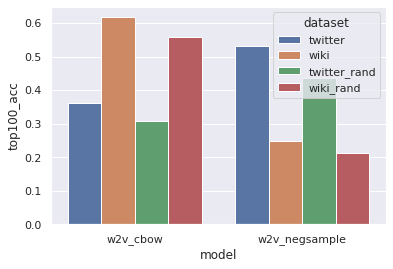

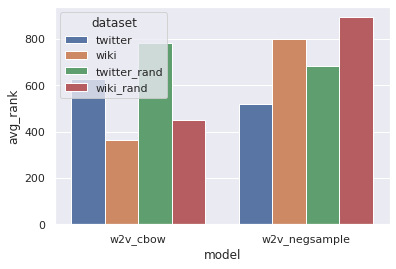

In [66]:
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': ['w2v_cbow', 'w2v_negsample', 'w2v_cbow', 'w2v_negsample',
              'w2v_cbow', 'w2v_negsample', 'w2v_cbow', 'w2v_negsample'],
    'dataset': ['twitter', 'wiki', 'wiki', 'twitter', 'twitter_rand', 'wiki_rand', 'wiki_rand', 'twitter_rand',],
    'avg_rank': [twitter_w2v_cbow_avgrank, wiki_w2v_negsample_avgrank, wiki_w2v_cbow_avgrank,
                 twitter_w2v_negsample_avgrank, twitterrand_w2v_cbow_avgrank, wikirand_w2v_negsample_avgrank, wikirand_w2v_cbow_avgrank,
                 twitterrand_w2v_negsample_avgrank],
    'top100_acc': [twitter_w2v_cbow_top100acc, wiki_w2v_negsample_top100acc, wiki_w2v_cbow_top100acc,
                   twitter_w2v_negsample_top100acc, twitterrand_w2v_cbow_top100acc, wikirand_w2v_negsample_top100acc, wikirand_w2v_cbow_top100acc,
                   twitterrand_w2v_negsample_top100acc],
    
})

sns.barplot(data=df, x='model', y='top100_acc', hue='dataset')
plt.show()

sns.barplot(data=df, x='model', y='avg_rank', hue='dataset')
plt.show()


## Contextual LMs

### load datasets

#### restricted vocab datasets

In [17]:
clm_test_ds_twitter, clm_test_ds_twitter_rand, twitter_pi_dict = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=w2v_twitter_negsamp_model.wv.key_to_index,
    w2v=False
)

clm_test_ds_wiki, clm_test_ds_wiki_rand, wiki_pi_dict = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=w2v_wiki_negsamp_model.wv.key_to_index,
    w2v=False
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 692671
total PIs: 4750
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 61475
total PIs: 3922


#### full test dataset

In [3]:
clm_test_ds_full_twitter, _, twitter_pi_dict_full = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=None,
    w2v=False,
    filter_th=10
)

clm_test_ds_full_wiki, _, wiki_pi_dict_full = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=None,
    w2v=False,
    filter_th=None
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 1546001
total test bios after freq filter: 1001456
total PIs: 49688
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 66484
total PIs: 15290


#### target restricted dataset

In [37]:
fixed_target_twitter_clm_ds = [(x[1], x[2]) for x in test_ds_twitter_target_restricted]
fixed_target_wiki_clm_ds = [(x[1], x[2]) for x in test_ds_wiki_target_restricted]

### load different models

#### load BERT

In [6]:
from transformers import BertTokenizer, BertModel, BertConfig
import torch

device = 'cuda:1'

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", config=config)
bert_model = bert_model.to(device)
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

#### load BerTweet

In [7]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:1'
bertweet_model = AutoModel.from_pretrained("vinai/bertweet-base")
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

bertweet_model = bertweet_model.to(device)
bertweet_model.eval()

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from t

CPU times: user 2.19 s, sys: 299 ms, total: 2.49 s
Wall time: 3.86 s


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(130, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

#### load sentenceBERT

In [8]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel

device = 'cuda:1'

sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
sbert_model.eval()


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


CPU times: user 1.27 s, sys: 20.7 ms, total: 1.29 s
Wall time: 1.46 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

#### load sentenceBERT fine-tuned

In [9]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:1'
twitter_ft_sbert = SentenceTransformer('./models/miniLM-L6-twitter-out256/', device=device)
twitter_ft_sbert.eval()

wiki_ft_sbert = SentenceTransformer('./models/miniLM-L6-wiki-out256/', device=device)
wiki_ft_sbert.eval()


CPU times: user 922 ms, sys: 52.2 ms, total: 974 ms
Wall time: 2.73 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
  (3): Dense({'in_features': 384, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

## projection model 

### define dimensions

In [10]:
measures = [{
    "names": ['bad', 'good'],
    "group": "evaluation",
    "sets": [['bad', 'awful'], ['good', 'nice']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "evaluation",
    "names": ['bad', 'good'],
    "sets": [['bad', 'awful', 'negative', 'terrible', 'worse', 'horrible'],
             ['good', 'nice', 'positive', 'great', 'better', 'awesome']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "potency",
    "names": ['weak', 'strong'],
    "sets": [['powerless', 'little'], ['powerful', 'big']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "potency",
    "names": ['weak', 'strong'],
    "sets": [['powerless', 'little', 'weak', 'impotent', 'dominant'],
             ['powerful', 'big', 'strong', 'potent', 'feeble']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group":
    "activity",
    "names": ['inactive', 'active'],
    "sets": [['slow', 'quiet', 'inactive'], ['fast', 'noisy', 'active']],
    "paper":
    "this_short",
    "is_paired":
    True
}, {
    "group":
    "activity",
    "names": ['inactive', 'active'],
    "sets": [['slow', 'quiet', 'inactive', 'dead', 'die', 'stopped'],
             ['fast', 'noisy', 'active', 'alive', 'live', 'moving']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "age",
    "names": ['young', 'old'],
    "sets": [['young'], ['old']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "age",
    "names": ['young', 'old'],
    "sets": [['young', 'new', 'youthful', 'young'],
             ['old', 'old', 'elderly', 'aged']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['female'], ['male']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['she'], ['he']],
    "paper": "gonen",
    "is_paired": True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'girl', 'she', 'mother', 'daughter', 'gal', 'female', 'her',
        'herself', 'Mary'
    ],
             [
                 'man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his',
                 'himself', 'John'
             ]],
    "paper":
    "bolukbasi_words",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets":
    [['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna'],
     ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']],
    "paper":
    "bolukbasi_names",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'women', 'she', 'her', 'her', 'hers', 'girl', 'girls',
        'female', 'feminine'
    ],
             [
                 'man', 'men', 'he', 'him', 'his', 'his', 'boy', 'boys',
                 'male', 'masculine'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}]

institutions = [
    'family', 'politics', 'justice', 'medicine', 'business', 'education',
    'religion'
]
race_ethnicities = ['white', 'latino', 'asian', 'middle eastern', 'black']

measures += [{
    "sets": [[x] for x in institutions],
    "names": institutions,
    "group": "instituiton",
    "paper": "this_short",
    "is_paired": False
}, {
    "sets": [[
        'family', 'kinsperson', 'household', 'kinfolk', 'home', 'kinsfolk',
        'kin'
    ], ['politics', 'government', 'political'],
             ['justice', 'law', 'legal', 'illegal'],
             ['medicine', 'medical', 'prescription', 'medication'],
             [
                 'business', 'job', 'profession', 'career', 'employment',
                 'occupation', 'clientele'
             ],
             ['education', 'school', 'university', 'instruction', 'teaching'],
             ['religion', 'faith', 'worship']],
    "names":
    institutions,
    "group":
    "instituiton",
    "paper":
    "this_long",
    "is_paired":
    False
}, {
    "sets": [['white', 'White'], ['hispanic', 'Hispanic', 'latino', 'Latino'],
             ['asian', 'Asian'], ['arab', 'Arab'], ['black', 'Black']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_short",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'Latino',
         'Hispanic'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     ['arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslim', 'Muslim'],
     ['black', 'blacks', 'Black', 'Blacks', 'African', 'African', 'Afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski",
    "is_paired":
    False
}, {
    "sets": [['white', 'whites', 'european', 'caucasian', 'anglo'],
             ['hispanic', 'hispanics', 'mexican', 'latino', 'hispanic'],
             ['asian', 'asians', 'chinese', 'japanese', 'korean'],
             ['arab', 'arabs', 'muslims', 'muslim', 'arab'],
             ['black', 'blacks', 'african', 'african', 'afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski_lowercase",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
         'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
         'Latinas'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     [
         'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim',
         'Muslims'
     ], [
         'black',
         'blacks',
         'Black',
         'Blacks',
         'African',
         'African',
     ]],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_long",
    "is_paired":
    False
}]

measures += [{
    "group":
    "openness",
    "names": ['open', 'closed'],
    "sets": [[
        "intelligent", "perceptive", "analytical", "reflective", "curious",
        "imaginative", "creative", "cultured", "refined", "sophisticated"
    ],
             [
                 "unintelligent", "imperceptive", "unanalytical",
                 "unreflective", "uninquisitive", "unimaginative",
                 "uncreative", "uncultured", "unrefined", "unsophisticated"
             ]],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "conscientiousness",
    "names": ['conscientious', 'unconscientious'],
    "sets": [
        [
            "organized", "responsible", "reliable", "conscientious",
            "practical", "thorough", "hardworking", "thrifty", "cautious",
            "serious"
        ],
        [
            "disorganized", "irresponsible", "undependable", "negligent",
            "impractical", "careless", "lazy", "extravagant", "rash",
            "frivolous"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "extroversion",
    "names": ['extroverted', 'introverted'],
    "sets": [
        [
            "extroverted", "energetic", "talkative", "enthusiastic", "bold",
            "active", "spontaneous", "assertive", "adventurous", "sociable"
        ],
        [
            "introverted", "unenergetic", "silent", "unenthusiastic", "timid",
            "inactive", "inhibited", "unassertive", "unadventurous",
            "unsociable"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "agreeableness",
    "names": ['agreeable', 'unagreeable'],
    "sets": [
        [
            "warm", "kind", "cooperative", "unselfish", "polite", "agreeable",
            "trustful", "generous", "flexible", "fair"
        ],
        [
            "cold", "unkind", "uncooperative", "selfish", "rude",
            "disagreeable", "distrustful", "stingy", "inflexible", "unfair"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "neuroticism",
    "names": ['neurotic', 'calm'],
    "sets": [
        [
            "angry", "tense", "nervous", "envious", "unstable", "discontented",
            "insecure", "emotional", "guilt-ridden", "moody"
        ],
        [
            "calm", "relaxed", "at ease", "not envious", "stable", "contended",
            "secure", "unemotional", "guilt-free", "steady"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}]

measures += [{
    "group":
    "cultivation",
    "names": ['uncultivated', 'cultivated'],
    "sets": [[
        'uncultivated', 'uncultured', 'uncivilized', 'discourteous',
        'improper', 'rude', 'uncordial', 'informal', 'uncourtly', 'boorish',
        'unpolished', 'unrefined', 'incivility', 'uncivil', 'boorishness',
        'rudeness', 'loutish', 'unmannerly', 'gruff', 'ungracious',
        'unobliging', 'uncultured', 'ungenteel', 'unmannered', 'blunt'
    ],
             [
                 'cultivated', 'cultured', 'civilized', 'courteous', 'proper',
                 'polite', 'cordial', 'formal', 'courtly', 'urbane',
                 'polished', 'refined', 'civility', 'civil', 'urbanity',
                 'politesse', 'edified', 'mannerly', 'polished', 'gracious',
                 'obliging', 'cultured', 'genteel', 'mannered', 'polite'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "employment",
    "names": ['employee', 'employer'],
    "sets": [[
        'employee', 'employees', 'worker', 'worker', 'laborer', 'laborers',
        'employee', 'employees', 'proletarian', 'proletariat', 'staff',
        'staff', 'employee', 'employees', 'worker', 'workers', 'laborer',
        'laborers', 'staff', 'staff'
    ],
             [
                 'employer', 'employers', 'owner', 'owners', 'industrialist',
                 'industrialists', 'proprietor', 'proprietors', 'capitalist',
                 'capitalists', 'manager', 'managers', 'director', 'directors',
                 'boss', 'bosses', 'foreman', 'foremen', 'supervisor',
                 'superintendent'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "education",
    "names": ['uneducated', 'educated'],
    "sets": [[
        'uneducated', 'unlearned', 'ignorant', 'untrained', 'untaught',
        'illiterate', 'unschooled', 'untutored', 'unlettered'
    ],
             [
                 'educated', 'learned', 'knowledgeable', 'trained', 'taught',
                 'literate', 'schooled', 'tutored', 'lettered'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "status",
    "names": ['low_status', 'high_status'],
    "sets": [[
        'unprestigious', 'dishonorable', 'lowly', 'uninfluential',
        'disreputable', 'commonplace', 'mundane', 'humble', 'prosaic',
        'modest', 'commoner', 'unpretentious', 'ordinary', 'lowly', 'common'
    ],
             [
                 'prestigious', 'honorable', 'esteemed', 'influential',
                 'reputable', 'distinguished', 'eminent', 'illustrious',
                 'renowned', 'acclaimed', 'dignitary', 'venerable', 'exalted',
                 'estimable', 'prominent'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "morality",
    "names": ['immoral', 'moral'],
    "sets": [[
        'evil', 'immoral', 'bad', 'dishonest', 'sinful', 'vice', 'wicked',
        'transgressive', 'unprincipled', 'questionable', 'nefarious',
        'corrupt', 'unscrupulous', 'selfish', 'knavish', 'crooked',
        'reprehensible', 'impure', 'undignified', 'unholy', 'fiendish',
        'villainous', 'guilty', 'indecent', 'unsavory', 'odious', 'unethical'
    ],
             [
                 'good', 'moral', 'good', 'honest', 'virtuous', 'virtue',
                 'righteous', 'chaste', 'principled', 'unquestionable',
                 'noble', 'uncorrupt', 'scrupulous', 'altruistic',
                 'chivalrous', 'honest', 'commendable', 'pure', 'dignified',
                 'holy', 'valiant', 'upstanding', 'guiltless', 'decent',
                 'chaste', 'righteous', 'ethical'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "affluence",
    "names": ['poor', 'rich'],
    "sets": [[
        'poor', 'poorer', 'poorest', 'poverty', 'destitute', 'needy',
        'impoverished', 'economical', 'impecunious', 'inexpensive', 'ruined',
        'necessitous', 'skint', 'cheap', 'economical', 'penurious',
        'threadbare', 'cheap', 'unmonied', 'indigent', 'threadbare',
        'penurious', 'cheap', 'worthless', 'underprivileged', 'bankrupt',
        'unprosperous', 'underdeveloped', 'insolvency', 'unsuccessful',
        'plain', 'basic', 'disadvantaged', 'squalid', 'valueless', 'beggarly',
        'ramshackle', 'indigence', 'insolvent', 'moneyless', 'penniless',
        'penury', 'plain', 'indigence'
    ],
             [
                 'rich', 'richer', 'richest', 'affluence', 'affluent',
                 'advantaged', 'wealthy', 'costly', 'exorbitant', 'expensive',
                 'exquisite', 'extravagant', 'flush', 'invaluable', 'lavish',
                 'luxuriant', 'luxurious', 'luxury', 'moneyed', 'opulent',
                 'plush', 'luxuriant', 'precious', 'priceless', 'privileged',
                 'propertied', 'prosperous', 'developed', 'solvency',
                 'successful', 'sumptuous', 'swanky', 'thriving', 'upscale',
                 'valuable', 'classy', 'ritzy', 'opulence', 'solvent',
                 'moneyed', 'rich', 'affluence', 'posh', 'opulence'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}]

measures.append({
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        "she", "daughter", "hers", "her", "mother", "woman", "girl", "herself",
        "female", "sister", "daughters", "mothers", "women", "girls", "femen",
        "sisters", "aunt", "aunts", "niece", "nieces"
    ],
             [
                 "he", "son", "his", "him", "father", "man", "boy", "himself",
                 "male", "brother", "sons", "fathers", "men", "boys", "males",
                 "brothers", "uncle", "uncles", "nephew", "nephews"
             ]],
    "paper":
    "garg",
    "is_paired":
    True
})

### get poles

In [11]:
dims = {}
for m in measures:
    if m['group'] in dims:
        dims[m['group']][0].extend(m['sets'][0])
        dims[m['group']][1].extend(m['sets'][1])
    else:
        dims[m['group']] = [m['sets'][0], m['sets'][1]]
        
for g, p in dims.items():
    p[0] = list(set(p[0]))
    p[1] = list(set(p[1]))
    
len(dims), dims['evaluation']

(18,
 [['terrible', 'horrible', 'bad', 'negative', 'worse', 'awful'],
  ['awesome', 'good', 'better', 'positive', 'nice', 'great']])

### generate embeddings

In [47]:
from numpy import linalg as LA
import numpy as np


def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / (norms[:, np.newaxis]+1e-6)
    return wv


def ripa(w, b):
    return w.dot(b)/LA.norm(b)


def normalize_dict(wv_dict):
    norm_voc = {}
    embs = []
    words = []
    for w, e in wv_dict.items():
        embs.append(e)
        words.append(w)
    embs = normalize(np.array(embs))
    
    for w, e in zip(words, embs):
        norm_voc[w] = e
    
    return norm_voc

def get_contextual_emb(model, word_list, w2v, tokenizer):
    if w2v:
        return model.wv.get_mean_vector(word_list)
    
    ctxt = ','.join(word_list)
    if tokenizer is None:        
        res = get_sbertbased_results_batched(model, [ctxt,], bs=512).numpy()
    else:
        res = get_results_batched(model, tokenizer, [ctxt,], average_k_layers=3, bs=512).numpy()
        
    return res[0]
        

def get_proj_embeddings(model, vocab_set, w2v=True, tokenizer=None):
    pole_voc = {}
    
    print("getting pole embeddings")
    for group, poles in dims.items():
        pole_voc[group] = get_contextual_emb(model, poles[0], w2v, tokenizer) -\
                                get_contextual_emb(model, poles[1], w2v, tokenizer)
    
    print("getting contextual embeddings")
    pi_embs = {}
    if w2v:
        bios = []
        # each vocab is the whole bio
        for ctxt in vocab_set:
            ctxt = ctxt.split(",")
            ctxt = [c.strip() for c in ctxt]
            bios.append(ctxt)
        embs = []
        for pis in tqdm(bios):
            embs.append(model.wv.get_mean_vector(pis))
    else:
        if tokenizer is None:        
            embs = get_sbertbased_results_batched(model, vocab_set, bs=512).numpy()
        else:
            embs = get_results_batched(model, tokenizer, vocab_set, average_k_layers=3, bs=512).numpy()

    for pi, e in zip(vocab_set, embs):
        pi_embs[pi] = e 
            
    print("normalizing embeddings")
    pole_voc = normalize_dict(pole_voc)
    pi_embs = normalize_dict(pi_embs)
    
    pi_prj_embs = {}
    print("calculating projections")
    for pi, e in tqdm(pi_embs.items()):
        prj = []
        for group, diff in pole_voc.items():
            prj.append(ripa(e, diff))
        pi_prj_embs[pi] = np.array(prj)
        
    return pi_prj_embs
    

In [48]:
pis_ctxt, ys = zip(*fixed_target_twitter_clm_ds)
pis_ctxt = list(pis_ctxt)
pis_ctxt.extend(ys)
all_pis_twitter = list(set(pis_ctxt))

pis_ctxt, ys = zip(*fixed_target_wiki_clm_ds)
pis_ctxt = list(pis_ctxt)
pis_ctxt.extend(ys)
all_pis_wiki = list(set(pis_ctxt))

print(f"all pis twitter: {len(all_pis_twitter)}")
print(f"all pis wiki: {len(all_pis_wiki)}")

all pis twitter: 2362829
all pis wiki: 69085


In [49]:
twitter_prj_embs_w2v_negsampling = get_proj_embeddings(
    model=w2v_twitter_negsamp_model,
    vocab_set=all_pis_twitter,
    w2v=True,
    tokenizer=None
)

wiki_prj_embs_w2v_cbow = get_proj_embeddings(
    model=w2v_wiki_cbow_model,
    vocab_set=all_pis_wiki,
    w2v=True,
    tokenizer=None
)

getting pole embeddings
getting contextual embeddings


100%|██████████| 2362829/2362829 [01:08<00:00, 34659.30it/s]


normalizing embeddings
calculating projections


100%|██████████| 2362829/2362829 [03:43<00:00, 10575.50it/s]


getting pole embeddings
getting contextual embeddings


100%|██████████| 69085/69085 [00:01<00:00, 35237.65it/s]


normalizing embeddings
calculating projections


  0%|          | 0/69085 [00:00<?, ?it/s]/scratch/12453279/ipykernel_21255/2984262842.py:13: RuntimeWarning: invalid value encountered in float_scalars
  return w.dot(b)/LA.norm(b)
100%|██████████| 69085/69085 [00:07<00:00, 9312.56it/s]


In [54]:
import pickle

def save_prj_model(model_name, model):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        
save_prj_model('twitter_prj_embs_w2v_negsampling', twitter_prj_embs_w2v_negsampling)
save_prj_model('wiki_prj_embs_w2v_cbow', wiki_prj_embs_w2v_cbow)


In [50]:
twitter_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=bert_tokenizer
)

twitter_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_bertweet = get_proj_embeddings(
    model=bertweet_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=bertweet_tokenizer
)

wiki_prj_embs_bertweet = get_proj_embeddings(
    model=bertweet_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=bertweet_tokenizer
)

twitter_prj_embs_ftbert = get_proj_embeddings(
    model=twitter_ft_sbert,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_ftbert = get_proj_embeddings(
    model=wiki_ft_sbert,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=None
)

getting pole embeddings


512it [00:00, 655.85it/s]            
512it [00:00, 56102.29it/s]          
512it [00:00, 56536.53it/s]          
512it [00:00, 57094.19it/s]          
512it [00:00, 57075.98it/s]          
512it [00:00, 57494.68it/s]          
512it [00:00, 57476.21it/s]          
512it [00:00, 58334.93it/s]          
512it [00:00, 45234.94it/s]          
512it [00:00, 48675.91it/s]          
512it [00:00, 53341.70it/s]          
512it [00:00, 57290.67it/s]          
512it [00:00, 53750.25it/s]          
512it [00:00, 53805.46it/s]          
512it [00:00, 53059.66it/s]          
512it [00:00, 51757.82it/s]          
512it [00:00, 53137.12it/s]          
512it [00:00, 51236.70it/s]          
512it [00:00, 52719.68it/s]          
512it [00:00, 50404.50it/s]          
512it [00:00, 53498.51it/s]          
512it [00:00, 53110.84it/s]          
512it [00:00, 53036.07it/s]          
512it [00:00, 53233.28it/s]          
512it [00:00, 49664.28it/s]          
512it [00:00, 51289.32it/s]          
512it [00:00

getting contextual embeddings


 73%|███████▎  | 1731072/2362829 [19:58<07:18, 1440.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2362829/2362829 [03:49<00:00, 10289.65it/s]


getting pole embeddings


512it [00:00, 38609.22it/s]          
512it [00:00, 87502.39it/s]          
512it [00:00, 88373.81it/s]          
512it [00:00, 87813.68it/s]          
512it [00:00, 88885.91it/s]          
512it [00:00, 88874.88it/s]          
512it [00:00, 91969.32it/s]          
512it [00:00, 89807.78it/s]          
512it [00:00, 78512.86it/s]          
512it [00:00, 78691.23it/s]          
512it [00:00, 83232.57it/s]          
512it [00:00, 93666.14it/s]          
512it [00:00, 81507.71it/s]          
512it [00:00, 81808.90it/s]          
512it [00:00, 81092.20it/s]          
512it [00:00, 79448.16it/s]          
512it [00:00, 82228.66it/s]          
512it [00:00, 78172.75it/s]          
512it [00:00, 80121.02it/s]          
512it [00:00, 76838.54it/s]          
512it [00:00, 80318.80it/s]          
512it [00:00, 80771.94it/s]          
512it [00:00, 80972.95it/s]          
512it [00:00, 79787.61it/s]          
512it [00:00, 78461.22it/s]          
512it [00:00, 81445.88it/s]          
512it [00:00

getting contextual embeddings


69120it [00:14, 4873.40it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 69085/69085 [00:06<00:00, 10340.00it/s]


getting pole embeddings


512it [00:00, 37655.99it/s]          
512it [00:00, 39249.97it/s]          
512it [00:00, 53537.19it/s]          
512it [00:00, 54494.98it/s]          
512it [00:00, 54056.02it/s]          
512it [00:00, 52477.49it/s]          
512it [00:00, 56224.21it/s]          
512it [00:00, 56627.47it/s]          
512it [00:00, 38553.77it/s]          
512it [00:00, 38527.49it/s]          
512it [00:00, 50548.06it/s]          
512it [00:00, 55467.60it/s]          
512it [00:00, 49739.05it/s]          
512it [00:00, 50564.72it/s]          
512it [00:00, 45210.18it/s]          
512it [00:00, 42425.30it/s]          
512it [00:00, 43457.25it/s]          
512it [00:00, 41819.70it/s]          
512it [00:00, 44635.09it/s]          
512it [00:00, 40181.19it/s]          
512it [00:00, 46121.94it/s]          
512it [00:00, 46670.22it/s]          
512it [00:00, 45170.24it/s]          
512it [00:00, 50138.54it/s]          
512it [00:00, 33748.49it/s]          
512it [00:00, 37969.58it/s]          
512it [00:00

getting contextual embeddings


 47%|████▋     | 1112576/2362829 [09:30<11:53, 1753.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 2362829/2362829 [03:40<00:00, 10696.87it/s]


getting pole embeddings


512it [00:00, 13595.02it/s]          
512it [00:00, 85916.53it/s]          
512it [00:00, 86770.52it/s]          
512it [00:00, 88432.04it/s]          
512it [00:00, 86002.55it/s]          
512it [00:00, 86865.29it/s]          
512it [00:00, 86188.94it/s]          
512it [00:00, 87416.90it/s]          
512it [00:00, 78335.29it/s]          
512it [00:00, 78044.91it/s]          
512it [00:00, 79131.98it/s]          
512it [00:00, 87264.16it/s]          
512it [00:00, 80969.90it/s]          
512it [00:00, 80198.81it/s]          
512it [00:00, 79610.14it/s]          
512it [00:00, 79407.03it/s]          
512it [00:00, 79237.09it/s]          
512it [00:00, 77900.52it/s]          
512it [00:00, 79586.54it/s]          
512it [00:00, 78084.64it/s]          
512it [00:00, 79749.10it/s]          
512it [00:00, 82427.50it/s]          
512it [00:00, 82408.52it/s]          
512it [00:00, 80478.33it/s]          
512it [00:00, 56208.02it/s]          
512it [00:00, 81952.51it/s]          
512it [00:00

getting contextual embeddings


69120it [00:12, 5494.87it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 69085/69085 [00:06<00:00, 10728.61it/s]


In [55]:
save_prj_model('twitter_prj_embs_bert', twitter_prj_embs_bert)
save_prj_model('wiki_prj_embs_bert', wiki_prj_embs_bert)

save_prj_model('twitter_prj_embs_sbert', twitter_prj_embs_sbert)
save_prj_model('wiki_prj_embs_sbert', wiki_prj_embs_sbert)

save_prj_model('twitter_prj_embs_bertweet', twitter_prj_embs_bertweet)
save_prj_model('wiki_prj_embs_bertweet', wiki_prj_embs_bertweet)

save_prj_model('twitter_prj_embs_ftbert', twitter_prj_embs_ftbert)
save_prj_model('wiki_prj_embs_ftbert', wiki_prj_embs_ftbert)


### load models

### calculate metrics

In [ ]:
%%time
import torch
from tqdm import tqdm
from torch.nn.functional import log_softmax


def calculate_prj_metrics(prj_model, dataset, cosine_bs=512):
    print("calculating embeddings...")
    X, ys = zip(*dataset)

    pi_list = list(set(ys))
    pi_dict = {}
    for pi in pi_list:
        pi_dict[pi] = len(pi_dict)
        
    
    emb_x = torch.tensor([prj_model[x] for x in X])
    emb_all = torch.tensor([prj_model[y] for y in pi_list])

    print("calculating ranks...")
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    return avg_rank, top100_acc, avg_score



In [65]:
twitter_w2v_prj_avg_rank, twitter_w2v_prj_top100acc, twitter_w2v_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_w2v_negsampling, fixed_target_twitter_clm_ds)
twitter_bert_prj_avg_rank, twitter_bert_prj_top100acc, twitter_bert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_bert, fixed_target_twitter_clm_ds)
twitter_bertweet_prj_avg_rank, twitter_bertweet_prj_top100acc, twitter_bertweet_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_bertweet, fixed_target_twitter_clm_ds)
twitter_sbert_prj_avg_rank, twitter_sbert_prj_top100acc, twitter_sbert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_sbert, fixed_target_twitter_clm_ds)
twitter_ftbert_prj_avg_rank, twitter_ftbert_prj_top100acc, twitter_ftbert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_ftbert, fixed_target_twitter_clm_ds)


calculating embeddings...
calculating ranks...


2628608it [00:09, 264074.81it/s]                             

1262.377197265625 0.21608866713565597 -8.324248313903809
calculating embeddings...


calculating ranks...


2628608it [00:10, 257576.02it/s]                             

2040.970458984375 0.04382145888651689 -8.44046401977539
calculating embeddings...


calculating ranks...


2628608it [00:09, 267475.27it/s]                             

2404.349609375 0.022210918116976182 -8.465845108032227
calculating embeddings...


calculating ranks...


2628608it [00:09, 266452.48it/s]                             

1673.84228515625 0.10619145797720012 -8.357454299926758
calculating embeddings...


calculating ranks...


2628608it [00:09, 263060.27it/s]                             

1166.7440185546875 0.17258565935167616 -8.15659236907959


In [67]:
wiki_w2v_prj_avg_rank, wiki_w2v_prj_top100acc, wiki_w2v_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_w2v_cbow, fixed_target_wiki_clm_ds)
wiki_bert_prj_avg_rank, wiki_bert_prj_top100acc, wiki_bert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_bert, fixed_target_wiki_clm_ds)
wiki_bertweet_prj_avg_rank, wiki_bertweet_prj_top100acc, wiki_bertweet_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_bertweet, fixed_target_wiki_clm_ds)
wiki_sbert_prj_avg_rank, wiki_sbert_prj_top100acc, wiki_sbert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_sbert, fixed_target_wiki_clm_ds)
wiki_ftbert_prj_avg_rank, wiki_ftbert_prj_top100acc, wiki_ftbert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_ftbert, fixed_target_wiki_clm_ds)


calculating embeddings...
calculating ranks...


161280it [00:00, 268324.61it/s]                            


1934.0399169921875 0.013945214340805612 nan
calculating embeddings...
calculating ranks...


161280it [00:00, 294775.13it/s]                            


1524.441650390625 0.055258378324583884 -8.2371826171875
calculating embeddings...
calculating ranks...


161280it [00:00, 304297.52it/s]                            


1935.83837890625 0.03134874231831413 -8.27086067199707
calculating embeddings...
calculating ranks...


161280it [00:00, 304900.87it/s]                            


1194.17236328125 0.12878486303585202 -8.141091346740723
calculating embeddings...
calculating ranks...


161280it [00:00, 304000.64it/s]                            

264.6509704589844 0.5775383773293857 -7.665503978729248


## frequency baseline

In [41]:
from collections import Counter
from tqdm import tqdm

def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    return bios


def calculate_freq_ranks(dataset_name, dataset):

    bios = load_bios(dataset=dataset_name, mode='train')
    cntr = Counter()

    _, ys = zip(*dataset)
    y_set = set(ys)
    
    for bio in tqdm(bios):
        for pi in bio:
            if pi in y_set:
                cntr.update([pi])

    ranks_d = {item[1][0]: item[0] for item in enumerate(cntr.most_common())}
    ranks = [ranks_d[x] for x in ys]
    
    avg_rank = np.mean(ranks)
    top100_acc = np.sum(np.where(np.array(ranks)<=100, 1., 0.))/len(ranks)
    
    return avg_rank, top100_acc
    
    
twitter_freq_based_avg_rank, twitter_freq_based_top100acc = calculate_freq_ranks('twitter', fixed_target_twitter_clm_ds)
wiki_freq_based_avg_rank, wiki_freq_based_top100acc = calculate_freq_ranks('wiki', fixed_target_wiki_clm_ds)


100%|██████████| 788343/788343 [00:01<00:00, 667956.61it/s]


## calculate metrics

In [15]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax


def calculate_clm_based_metrics(clm_model, tokenizer, dataset, pi_dict,
                                default_encoder=False, device='cuda:1', cosine_bs=512, emb_bs=512):
    print("calculating embeddings...")
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    if default_encoder:        
        emb_x = get_sbertbased_results_batched(clm_model, X, bs=emb_bs)
        emb_all = get_sbertbased_results_batched(clm_model, pi_list, bs=emb_bs)
            
    else:
        emb_x = get_results_batched(clm_model, tokenizer, X, average_k_layers=3, bs=emb_bs)
        emb_all = get_results_batched(clm_model, tokenizer, pi_list, average_k_layers=3, bs=emb_bs)

    print("calculating ranks...")
#     device = 'cuda'
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
#         print(torch.sum(batch_softmax, dim=1), torch.sum(batch_softmax, dim=1).shape)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
#     print(softmax_scores)

    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])/emb_x.shape[0]
    del target_ranks
    
    print(avg_rank, top100_acc, avg_score)
    
    return avg_rank, top100_acc, avg_score

CPU times: user 429 µs, sys: 0 ns, total: 429 µs
Wall time: 350 µs


### restricted target experiments

In [16]:
%%time

# sbert and its finetuned
twitter_sbertft_avg_rank, twitter_sbertft_top100acc, twitter_sbertft_avg_score = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=True
)

twitter_sbert_avg_rank, twitter_sbert_top100acc, twitter_sbert_avg_score =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=True
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc, wiki_sbertft_avg_score =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=True
)

wiki_sbert_avg_rank, wiki_sbert_top100acc, wiki_sbert_avg_score =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=True
)

# bert and bertweet

twitter_bert_avg_rank, twitter_bert_top100acc, twitter_bert_avg_score = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=False
)

twitter_bertweet_avg_rank, twitter_bertweet_top100acc, twitter_bertweet_avg_score =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=False
)

wiki_bert_avg_rank, wiki_bert_top100acc, wiki_bert_avg_score = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc, wiki_bertweet_avg_score =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False
)

calculating embeddings...


 71%|███████   | 1857024/2628347 [07:34<03:18, 3888.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2628608it [19:16, 2273.47it/s]                             
5120it [00:00, 9200.02it/s]                           


calculating ranks...


2628608it [00:18, 141473.30it/s]                             


2237.533447265625 0.040438343947735975 -8.46589183807373
calculating embeddings...


 50%|████▉     | 79872/160772 [00:21<00:23, 3406.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### full bio metrics

In [ ]:
%%time
# sbert and its finetuned

twitter_sbertft_avg_rank, twitter_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

twitter_sbert_avg_rank, twitter_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

wiki_sbert_avg_rank, wiki_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

# bert and bertweet

twitter_bert_avg_rank, twitter_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

twitter_bertweet_avg_rank, twitter_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

wiki_bert_avg_rank, wiki_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

### random pi in bio metrics

In [22]:
%%time
# sbert and its finetuned

twitterrand_sbertft_avg_rank, twitterrand_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

twitterrand_sbert_avg_rank, twitterrand_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

wikirand_sbertft_avg_rank, wikirand_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

wikirand_sbert_avg_rank, wikirand_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

# bert and bertweet

twitterrand_bert_avg_rank, twitterrand_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

twitterrand_bertweet_avg_rank, twitterrand_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

wikirand_bert_avg_rank, wikirand_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

wikirand_bertweet_avg_rank, wikirand_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

calculating embeddings...
calculating ranks...
532.9867553710938 0.42402381505794234
calculating embeddings...
calculating ranks...
1390.777587890625 0.23102165385875834
calculating embeddings...
calculating ranks...
179.9920196533203 0.6743391622610817
calculating embeddings...
calculating ranks...
576.1998901367188 0.33472143147620986
calculating embeddings...


693000it [01:38, 7046.36it/s]                            
5000it [00:00, 6581.48it/s]                          


calculating ranks...
1717.3118896484375 0.1860710207298992
calculating embeddings...


693000it [00:56, 12223.32it/s]                            
5000it [00:00, 11208.42it/s]                          


calculating ranks...
2085.701416015625 0.08666452038557988
calculating embeddings...


62000it [00:09, 6691.33it/s]                           
4000it [00:00, 6742.17it/s]                          


calculating ranks...
1138.1964111328125 0.22705164701098007
calculating embeddings...


62000it [00:04, 12869.61it/s]                           
4000it [00:00, 13366.60it/s]                          


calculating ranks...
1147.90283203125 0.14090280601870678
CPU times: user 45min 30s, sys: 4min 4s, total: 49min 34s
Wall time: 10min 13s


### non restricted test dataset

In [6]:

twitter_bert_avg_rank, twitter_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

wiki_bert_avg_rank, wiki_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

calculating embeddings...


1001472it [07:54, 2109.77it/s]                             
50176it [00:09, 5041.84it/s]                           


calculating ranks...


1001472it [00:58, 17086.57it/s]                             


20652.9765625 0.04434243741112939
calculating embeddings...


66560it [00:26, 2541.59it/s]                           
15360it [00:03, 4228.71it/s]                           


calculating ranks...


66560it [00:01, 53508.87it/s]                           

4626.1787109375 0.11999879670296612


In [9]:
twitter_bertweet_avg_rank, twitter_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

calculating embeddings...


1001472it [06:20, 2635.04it/s]                             
50176it [00:05, 9535.37it/s]                            


calculating ranks...


1001472it [00:59, 16744.10it/s]                            


20539.037109375 0.025803430205620616
calculating embeddings...


66560it [00:24, 2672.00it/s]                           
15360it [00:01, 7821.63it/s]                            


calculating ranks...


66560it [00:01, 57001.96it/s]                           

5476.2080078125 0.04426628963359605


In [13]:

twitter_sbertft_avg_rank, twitter_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

twitter_sbert_avg_rank, twitter_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

wiki_sbert_avg_rank, wiki_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


calculating embeddings...


1001472it [03:01, 5532.70it/s]                             
50176it [00:08, 5667.16it/s]                           


calculating ranks...


1001472it [00:37, 27033.83it/s]                             

7994.1298828125 0.11363754373631992
calculating embeddings...



1001472it [03:03, 5466.32it/s]                             
50176it [00:08, 5757.22it/s]                           


calculating ranks...


1001472it [00:42, 23390.70it/s]                             


12793.62109375 0.10973422696553818
calculating embeddings...


66560it [00:12, 5184.58it/s]                           
15360it [00:02, 5654.10it/s]                           


calculating ranks...


66560it [00:00, 84545.14it/s]                           


1759.176513671875 0.34175139883280187
calculating embeddings...


66560it [00:11, 5603.73it/s]                           
15360it [00:02, 5663.36it/s]                           


calculating ranks...


66560it [00:00, 74342.99it/s]                           

1810.1021728515625 0.22927320859154082


### cross platform models

In [15]:

twitter_crossplt_sbertft_avg_rank, twitter_crossplt_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


wiki_crossplt_sbertft_avg_rank, wiki_crossplt_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


calculating embeddings...


1001472it [02:59, 5588.46it/s]                             
50176it [00:08, 5779.46it/s]                           


calculating ranks...


1001472it [00:35, 28313.08it/s]                             


22911.25 0.03132339313958876
calculating embeddings...


66560it [00:11, 5665.67it/s]                           
15360it [00:02, 5707.25it/s]                           


calculating ranks...


66560it [00:00, 79849.32it/s]                           

2829.21923828125 0.19821310390469887


## Full comparison

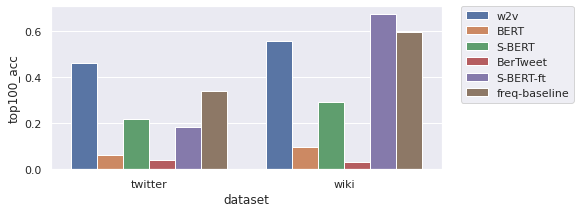

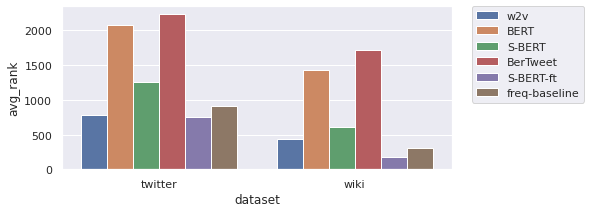

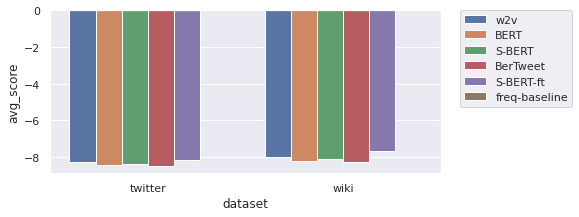

In [42]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'BerTweet',
        'BerTweet',
        'S-BERT-ft',
        'S-BERT-ft',
        'freq-baseline',
        'freq-baseline'
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitter_w2v_negsample_avgrank, 
        wiki_w2v_cbow_avgrank,
        twitter_bert_avg_rank,
        wiki_bert_avg_rank,
        twitter_sbert_avg_rank,
        wiki_sbert_avg_rank,
        twitter_bertweet_avg_rank,
        wiki_bertweet_avg_rank,
        twitter_sbertft_avg_rank,
        wiki_sbertft_avg_rank,
        twitter_freq_based_avg_rank,
        wiki_freq_based_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_negsample_avgscore, 
        wiki_w2v_cbow_avgscore,
        twitter_bert_avg_score,
        wiki_bert_avg_score,
        twitter_sbert_avg_score,
        wiki_sbert_avg_score,
        twitter_bertweet_avg_score,
        wiki_bertweet_avg_score,
        twitter_sbertft_avg_score,
        wiki_sbertft_avg_score,
        None,
        None,
    ],
    'top100_acc': [
        twitter_w2v_negsample_top100acc,
        wiki_w2v_cbow_top100acc,
        twitter_bert_top100acc,
        wiki_bert_top100acc,
        twitter_sbert_top100acc,
        wiki_sbert_top100acc,
        twitter_bertweet_top100acc,
        wiki_bertweet_top100acc,
        twitter_sbertft_top100acc,
        wiki_sbertft_top100acc,
        twitter_freq_based_top100acc,
        wiki_freq_based_top100acc
    ],
})

df.to_csv('fixed_target_results.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [45]:
(        twitter_w2v_negsample_avgscore, 
        twitter_bert_avg_score,
        twitter_sbert_avg_score,
        twitter_bertweet_avg_score,
        twitter_sbertft_avg_score,
), (

        wiki_w2v_cbow_avgscore,
        wiki_bert_avg_score,
        wiki_sbert_avg_score,
        wiki_bertweet_avg_score,
        wiki_sbertft_avg_score,
)

((-8.279070854187012,
  -8.453959465026855,
  -8.379989624023438,
  -8.46589183807373,
  -8.152100563049316),
 (-7.998246192932129,
  -8.239590644836426,
  -8.115586280822754,
  -8.26986026763916,
  -7.675154209136963))

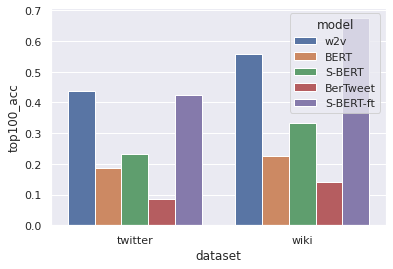

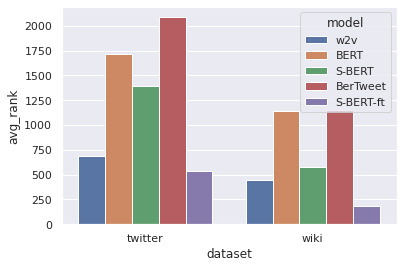

In [36]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'BerTweet',
        'BerTweet',
        'S-BERT-ft',
        'S-BERT-ft',
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitterrand_w2v_negsample_avgrank,
        wiki_w2v_cbow_avgrank,
        wikirand_w2v_cbow_avgrank,
        twitterrand_bert_avg_rank,
        wikirand_bert_avg_rank,
        twitterrand_sbert_avg_rank,
        wikirand_sbert_avg_rank,
        twitterrand_bertweet_avg_rank,
        wikirand_bertweet_avg_rank,
        twitterrand_sbertft_avg_rank,
        wikirand_sbertft_avg_rank,
    ],
    'top100_acc': [
        twitterrand_w2v_negsample_top100acc,
        wiki_w2v_cbow_top100acc
        wikirand_w2v_cbow_top100acc,
        twitterrand_bert_top100acc,
        wikirand_bert_top100acc,
        twitterrand_sbert_top100acc,
        wikirand_sbert_top100acc,
        twitterrand_bertweet_top100acc,
        wikirand_bertweet_top100acc,
        twitterrand_sbertft_top100acc,
        wikirand_sbertft_top100acc,
    ],
})

df.to_csv('result_restricted_randombio.csv', header=True, index=False)

sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.show()

sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.show()

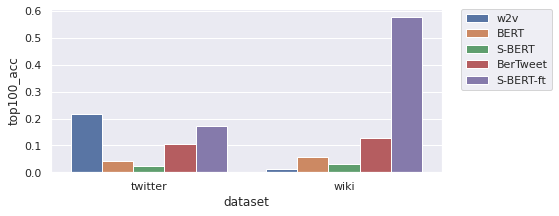

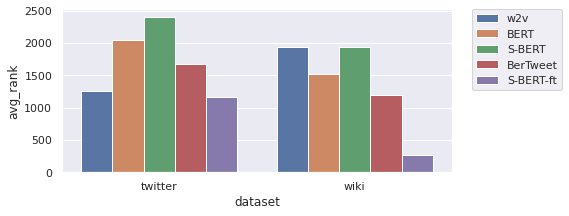

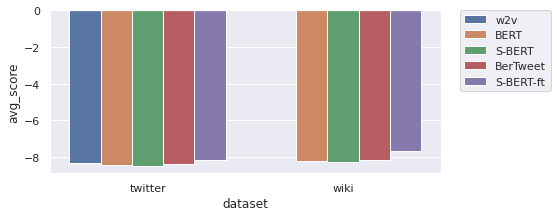

In [68]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'BerTweet',
        'BerTweet',
        'S-BERT-ft',
        'S-BERT-ft',
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitter_w2v_prj_avg_rank, 
        wiki_w2v_prj_avg_rank,
        twitter_bert_prj_avg_rank, 
        wiki_bert_prj_avg_rank,
        twitter_bertweet_prj_avg_rank, 
        wiki_bertweet_prj_avg_rank,
        twitter_sbert_prj_avg_rank, 
        wiki_sbert_prj_avg_rank,
        twitter_ftbert_prj_avg_rank, 
        wiki_ftbert_prj_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_prj_avg_score, 
        wiki_w2v_prj_avg_score,
        twitter_bert_prj_avg_score, 
        wiki_bert_prj_avg_score,
        twitter_bertweet_prj_avg_score, 
        wiki_bertweet_prj_avg_score,
        twitter_sbert_prj_avg_score, 
        wiki_sbert_prj_avg_score,
        twitter_ftbert_prj_avg_score, 
        wiki_ftbert_prj_avg_score,
    ],
    'top100_acc': [
        twitter_w2v_prj_top100acc, 
        wiki_w2v_prj_top100acc,
        twitter_bert_prj_top100acc, 
        wiki_bert_prj_top100acc,
        twitter_bertweet_prj_top100acc, 
        wiki_bertweet_prj_top100acc,
        twitter_sbert_prj_top100acc, 
        wiki_sbert_prj_top100acc,
        twitter_ftbert_prj_top100acc, 
        wiki_ftbert_prj_top100acc,
    ],
})

df.to_csv('fixed_target_projection_results.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# per sample comparison - top samples

## load best rankings for w2v and fine-tuned model on twitter

In [42]:
from sentence_transformers import SentenceTransformer, models, util

def get_topk_ranks(w2v_model, x, y ,pi_dict, device='cpu', k=50):
    pi_list = list(pi_dict.keys())
    inv_dict = {v:k for k,v in pi_dict.items()}
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x),], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_vector(x) for x in pi_list], device=device)
    
    i = 0

    cosine_scores = util.cos_sim(emb_x, emb_all)
    ranks = torch.argsort(cosine_scores, dim=1, descending=True)
    rankranks = torch.argsort(ranks, dim=1)
    
    top_idxs = ranks[0,:k].tolist()
    top_pis = [inv_dict[i] for i in top_idxs]
    target_idx = torch.tensor([pi_dict[y]], dtype=torch.int64)
    target_rank = torch.gather(rankranks, 1, target_idx.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor).tolist()[0][0]

    return target_rank, top_pis



get_topk_ranks(
    w2v_twitter_negsamp_model,
    x=['dsd', 'xxxxxx', 'sd;flskdf;'],
    y='maga',
    pi_dict=twitter_pi_dict,
)


(3147.0,
 ['larry',
  'arsenal fc',
  'savemyanmar',
  's s',
  'rise',
  'god bless america',
  'heritage',
  'digital marketing',
  'prof',
  'columnist',
  'communist',
  'fuck it',
  'so much more',
  'freedom of speech',
  '33',
  'red velvet',
  '100% follow back',
  'blink',
  'husband to',
  'kc',
  'pilot',
  'chenle',
  'supporting',
  'michigan',
  'chiefskingdom',
  'chair',
  'ua',
  'star',
  'gym rat',
  'packers',
  'online',
  'pussy',
  'pfp made by',
  'sr',
  'all views',
  'army forever',
  'netflix',
  'bds',
  'got7',
  'cd',
  '1a',
  'bts_twt',
  'intelligent',
  'christian',
  'bh',
  'kpop stan',
  'resistor',
  'many more',
  'president trump',
  'editor-in-chief'])

In [20]:
xs, ys = zip(*w2v_test_ds_twitter)
w2v_test_ds_twitter[:100]

[(['writer', 'reader', 'gamer', 'son', 'brother'], 'marine'),
 (['she', 'bts', 'txt'], 'her'),
 (['qualquer pronome'], 'official'),
 (['manutd'], 'imvkohli'),
 (['liverpool fan'], 'ynwa'),
 (['xxx'], 'meow'),
 (['sometimes i draw', '15', 'femboy'], 'mxico'),
 (['browns'], 'dodgers'),
 (['music', 'be nice'], 'support'),
 (['fanaccount'], 'army'),
 (['visual'], 'stan talent'),
 (['he'], 'him'),
 (['entrepreneur',
   'podcaster',
   'youtuber',
   'technologist',
   'strategist',
   'father'],
  'husband'),
 (['resist'], 'bidenharris'),
 (['her'], 'she'),
 (['tweets are mine'], 'of course'),
 (['dms', 'trolls', 'wwg1wga'], 'maga'),
 (['sci-fi', 'gadgets', 'fashion'], 'wine'),
 (['indian', 'actorvijay'], 'thalapathy'),
 (['stylist', 'content creator'], 'fashion designer'),
 (['entrepreneur', 'quality', 'shoes'], 'nurse'),
 (['she', 'her'], 'hers'),
 (['fantasy'], 'writing'),
 (['2pm', 'got7'], 'bambam'),
 (['one direction', 'her'], 'she'),
 (['19', 'them', 'pan', 'taken'], 'he'),
 (['other

# build survey questions

## neighborhood score + negative sampling choices

In [ ]:
import pandas as pd
from ast import literal_eval

df = pd.read_csv('twitter_pi_with_neighbors_tfidf.csv')
print(df.head())
df.positives = df.positives.apply(literal_eval)
df.negatives = df.negatives.apply(literal_eval)

In [ ]:
from tqdm import tqdm
from random import randint

pis = df['pis']
positives = df['positives']
negatives = df['negatives']

sample_cnt = 500
questions = []
targets = []
other_choices = []

sample_idices = np.random.randint(0, len(df), size=sample_cnt)

for qid in sample_idices:
    q = pis[qid]
    cur_pos = positives[qid]
    cur_neg = negatives[qid]
    target = cur_pos[randint(0,len(cur_pos)-1)]
    targets.append(target)
    questions.append(q)
    other_choices.append(np.random.choice(cur_neg, size=3, replace=False))
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('surrvey_tfidf_twitter.csv', index=False, header=True)

In [ ]:
!head surrvey_tfidf_twitter.csv -n 100

## model based question generation

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

fint_model = SentenceTransformer('./models/miniLM-L6-finetuned/')

In [ ]:
from tqdm import tqdm
from random import randint


all_pis = df['pis']
sims = df['similars']
sample_cnt = 500

questions = []
targets = []
other_choices = []

i = 0
while i < sample_cnt:
    idx = randint(0, len(all_pis)-1)
    questions.append(all_pis[idx])
    i += 1



In [ ]:
fint_emb_x = fint_model.encode(questions, convert_to_tensor=True)
fint_emb_all = fint_model.encode(all_pis, convert_to_tensor=True)


In [ ]:
import numpy as np

targets = []
other_choices = []

for x in tqdm(fint_emb_x):
    cosine_scores = util.cos_sim(x, fint_emb_all).detach().cpu().numpy()[0]
    argsort = np.argsort(cosine_scores)
    best_k = argsort[-6:-1]
    worst_k = argsort[:len(argsort)//2]
    
    target_idx = np.random.choice(best_k)
    targets.append(all_pis[target_idx])
    
    other_idxs = np.random.choice(worst_k, size=3, replace=False)
    other_choices.append([all_pis[x] for x in other_idxs])
    
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('modelbased-selection.csv', index=False, header=True)
    

In [ ]:
!head modelbased-selection.csv